In [1]:
import logging
import io
import requests
import os
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.optimize
import numpy as np

from heapq import nlargest

In [2]:
def download_csv_data(url):
    '''Downloads the data
    
    :param url: The data source URL
    '''
    if not url:
        return None

    s = requests.get(url).content
    return pd.read_csv(io.StringIO(s.decode('utf-8')))

df = download_csv_data('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

# Drop unnecessary columns
df = df.drop(['Province/State', 'Lat', 'Long'], axis=1)

# Group by Country/Region, sum the values and reset the index
df_grouped_summed = df.groupby('Country/Region').sum().reset_index()

# Gather all countries
all_countries_list = list(df_grouped_summed['Country/Region'])

# Image path to save the created plot images to (relative to the current directory)
PLOT_IMAGE_PATH = 'images'

# Plot configuration
PLOT_SIZE=(16, 6)
PLOT_TITLE = 'COVID-19 infections per country'
PLOT_LABEL_X = 'Date'
PLOT_LABEL_Y = 'Nr of infections'

df_grouped_summed = df.groupby('Country/Region').sum().reset_index()
dates = list(df_grouped_summed.columns.values)[1:]
date_first = datetime.datetime.strptime(dates[0], '%m/%d/%y')
date_last = datetime.datetime.strptime(dates[-1], '%m/%d/%y')

def save_plot(fig, path, date, name):
    '''Saves the plot of the fig to "<current_dir>/<name>"
    
    :param fig: The figure    
    :param path: The image path
    :param name: The name of the image
    '''
    try:
        curr_dir = os.getcwd()
        path_data = os.path.join(curr_dir, path if path else 'images', str(date.date()) if date else 'unknown')
        if not os.path.exists(path_data):
            os.makedirs(path_data)
        full_path = os.path.join(path_data, get_clean_image_name(name))
        logging.info('Saving plot to "{}"'.format(full_path))
        fig.savefig(full_path)
        return True
    except Exception as e:
        logging.info('Could not save plot to file "{}" in path "{}": {}'.format(name, path, e))
        return False

def func_fit(x, a, b):
    return a + b * x

def func_fit_plt(x, a, b):
    return np.exp(func_fit(x, a, b))

def delta_func_fit_plt(x, a, b):
    return b * np.exp(func_fit(x, a, b))

R = 3.50, H0 = 0.71
R = 1.91, H0 = 0.48


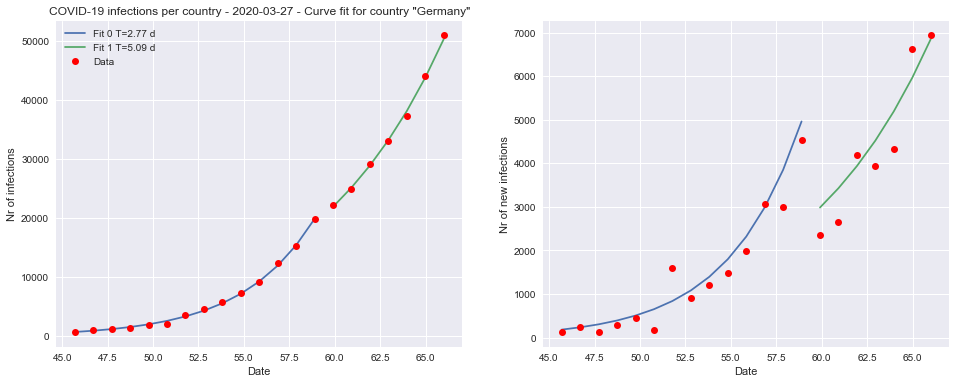

R = 2.82, H0 = 0.65
R = 2.16, H0 = 0.54
R = 1.05, H0 = 0.05


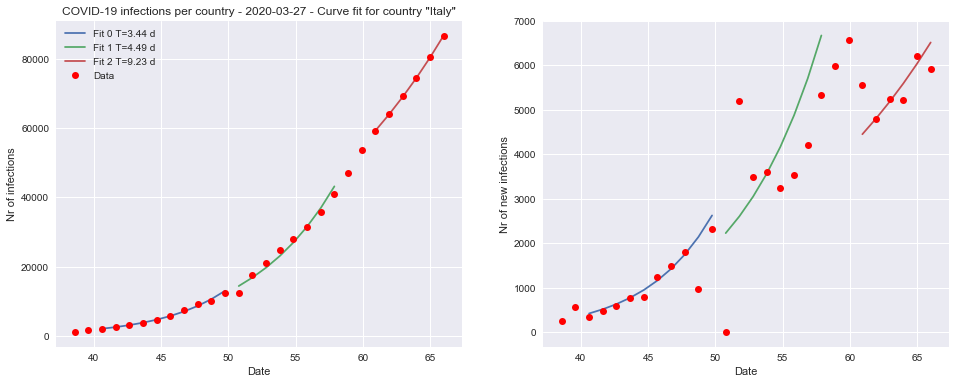

R = 3.05, H0 = 0.67


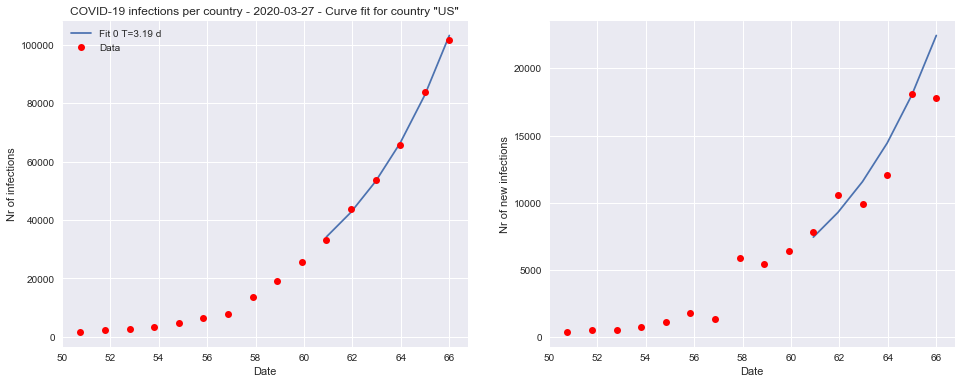

R = 4.35, H0 = 0.77
R = 1.06, H0 = 0.06
R = 0.17, H0 = -4.93
R = 0.12, H0 = -7.29


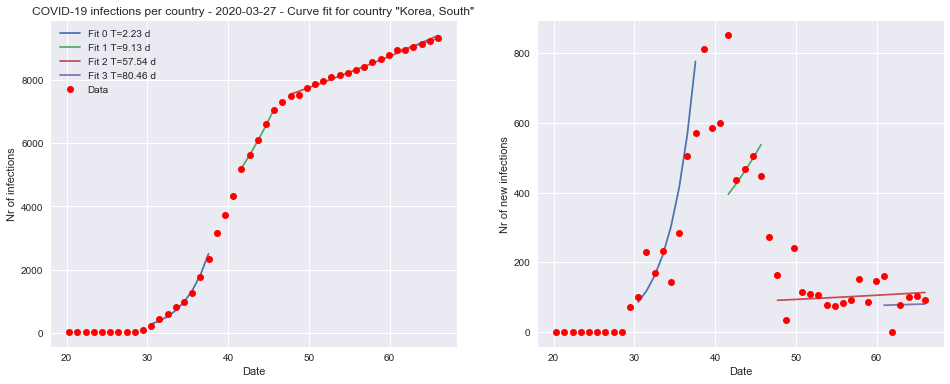

In [11]:
def FitDoublingTime(CURVE_FIT_COUNTRY, plot_range, fit_range):
    plot_name = 'Curve fit for country "{}"'.format(CURVE_FIT_COUNTRY)
    logging.info('Plotting "{}"'.format(plot_name))

    if CURVE_FIT_COUNTRY in all_countries_list:
        fig, ax = plt.subplots(1, 2, figsize=PLOT_SIZE)
        df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==CURVE_FIT_COUNTRY]
        # Unpivot a DataFrame from wide to long format, optionally leaving identifiers set.
        df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
        
        vals_x_plot = np.linspace(0, len(df_melted.Value), num = len(df_melted.Value))[plot_range[0]:plot_range[1]]
        vals_y_plot = list(df_melted.Value)[plot_range[0]:plot_range[1]]
        
        vals_deltay_plot = [list(df_melted.Value)[i] - list(df_melted.Value)[i-1]
                            for i in range(len(list(df_melted.Value)))][plot_range[0]:plot_range[1]]


        for i, fr in enumerate(fit_range):
            vals_x_to_fit = np.linspace(0, len(df_melted.Value)
                                        , num = len(df_melted.Value))[fr[0]:fr[1]]

            vals_y_to_fit = np.log(list(df_melted.Value)[fr[0]:fr[1]])

            params, params_cov = scipy.optimize.curve_fit(func_fit, xdata=vals_x_to_fit, ydata=vals_y_to_fit)

            vals_y_fit_plot = [func_fit_plt(x, *params) for x in vals_x_to_fit]

            vals_y_delta_fit = [delta_func_fit_plt(x, *params) for x in vals_x_to_fit]

            b = params[1]
            T = np.log(2)/b
            R = b * 14 # magicnumber - Ansteckungsdauer
            H0 = (1 - 1/R)
            print('R = {:.2f}, H0 = {:.2f}'.format(R, H0))

            ax[0].plot(vals_x_to_fit, vals_y_fit_plot, '-', 
                       label ='Fit {} T={:.2f} d'.format(i, T))
            #ax[0].plot(vals_x_plot, vals_y_fit_plot, '--', color ='blue', label ='Fit - etrapolation')

            ax[1].plot(vals_x_to_fit, vals_y_delta_fit, '-', 
                       label ='Fit {} T={:.2f} d'.format(i, T))

            #ax[1].plot(vals_x_plot, vals_y_delta_fit_plot, '--', color ='blue', label ='Fit T={:.2f} d'.format(np.log(2)/params[1]))

        ax[0].plot(vals_x_plot, vals_y_plot, 'o', color ='red', label ='Data') 
        ax[1].plot(vals_x_plot, vals_deltay_plot, 'o', color ='red', label ='Data') 
        
        
        ax[0].set_title('{} - {} - {}'.format(PLOT_TITLE, date_last.date(), plot_name), loc='center')
        ax[0].set_xlabel(PLOT_LABEL_X)
        ax[0].set_ylabel(PLOT_LABEL_Y)
        
        ax[1].set_xlabel(PLOT_LABEL_X)
        ax[1].set_ylabel('Nr of new infections')
        
        ax[0].legend()
        plt.show()

        save_plot(fig, PLOT_IMAGE_PATH, date_last, 'Curve-Fit-{}.png'.format(CURVE_FIT_COUNTRY))

        plt.close(fig)
    else:
        logging.info('Could not find given countday_endry "{}"'.format(CURVE_FIT_COUNTRY))

opts = [{'CURVE_FIT_COUNTRY': 'Germany',
                   'plot_range': [45, None],
                   'fit_range': [[45, 59], [-7, None]]},
{'CURVE_FIT_COUNTRY': 'Italy',
                   'plot_range': [38, None],
                   'fit_range': [[40,50], [50, 58], [-6, None]]},
{'CURVE_FIT_COUNTRY': 'US',
                   'plot_range': [50, None],
                   'fit_range': [[-6, None]]},
{'CURVE_FIT_COUNTRY': 'Korea, South',
                   'plot_range': [20, None],
                   'fit_range': [[30, 38], [41,46], [47, None], [-6, None]]}]

for m in opts:
    FitDoublingTime(**m)


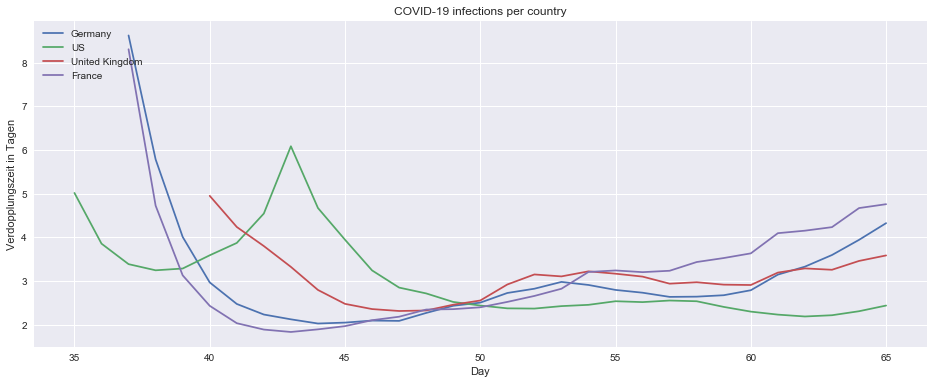

In [4]:
def fitDynamicDoublingTime(CURVE_FIT_COUNTRY, start, delta, stop = None):
    all_countries = list(df_grouped_summed['Country/Region'])
    lst_a = []
    lst_b = []
    lst_T = []

    df_tmp = df_grouped_summed[df_grouped_summed['Country/Region']==CURVE_FIT_COUNTRY]
    df_melted = df_tmp.melt(id_vars=df_tmp.columns.values[:1], var_name='Date', value_name='Value')
    _x0 = start
    _x_max = stop if stop else len(list(df_melted.Value)) 
    _delta = delta

    for j in range(_x_max - _x0 - _delta):
        vals_x = np.linspace(0, len(df_melted.Value), num = len(df_melted.Value))[_x0+j:_x0+j+_delta]
        vals_y = list(df_melted.Value)[_x0+j:_x0+j+_delta]

        # Scipy curve fit (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)
        params, params_cov = scipy.optimize.curve_fit(func_fit, 
                                                      xdata=vals_x, 
                                                      ydata=np.log(vals_y), 
                                                      p0=(0.8, 0.2))
        lst_T.append(np.log(2)/params[1])
        
    return [i for i in range(_x0+_delta, _x_max)], lst_T

def Plot(params):
    fig, ax = plt.subplots(figsize=PLOT_SIZE)

    for p in params:
        plt.plot(p[1][0], p[1][1], label=p[0])
        
    ax.set_title('{}'.format(PLOT_TITLE), loc='center')
    ax.set_xlabel('Day')
    ax.set_ylabel('Verdopplungszeit in Tagen')
    plt.legend(loc='upper left')
    plt.show()
    
    
delta = 10
opts2 = [{'CURVE_FIT_COUNTRY': 'Germany', 'start': 27, 'delta':delta},
         #{'CURVE_FIT_COUNTRY': 'Italy', 'start': 22, 'delta':delta},
         {'CURVE_FIT_COUNTRY': 'US', 'start': 25, 'delta':delta},
         {'CURVE_FIT_COUNTRY': 'United Kingdom', 'start': 30, 'delta':delta},
         {'CURVE_FIT_COUNTRY': 'France', 'start': 27, 'delta':delta},
         #{'CURVE_FIT_COUNTRY': 'Spain', 'start': 25, 'delta':delta},
         #{'CURVE_FIT_COUNTRY': 'Switzerland', 'start': 35, 'delta':delta},
         #{'CURVE_FIT_COUNTRY': 'Korea, South', 'start': 21, 'delta':delta, 'stop': 47},
        ]

Plot([[m['CURVE_FIT_COUNTRY'], fitDynamicDoublingTime(**m)] for m in opts2])